In [1]:
import os
import shutil
import random

# Paths for the dataset
train_path = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
validation_path = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"
output_train_path = "/kaggle/working/reduced_dataset/train"
output_validation_path = "/kaggle/working/reduced_dataset/valid"

train_samples = 500
validation_samples = 100


def create_subset(input_path, output_path, samples_per_class):
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    for class_name in os.listdir(input_path):
        class_dir = os.path.join(input_path, class_name)
        if os.path.isdir(class_dir):
            images = os.listdir(class_dir)
            random.shuffle(images)
            selected_images = images[:samples_per_class]
            class_output_dir = os.path.join(output_path, class_name)
            os.makedirs(class_output_dir, exist_ok=True)
            for image in selected_images:
                src = os.path.join(class_dir, image)
                dst = os.path.join(class_output_dir, image)
                shutil.copy(src, dst)
            print(f"Processed class '{class_name}' with {samples_per_class} images.")


create_subset(train_path, output_train_path, train_samples)
create_subset(validation_path, output_validation_path, validation_samples)

print("Subset creation completed.")



Processed class 'Tomato___Late_blight' with 500 images.
Processed class 'Tomato___healthy' with 500 images.
Processed class 'Grape___healthy' with 500 images.
Processed class 'Orange___Haunglongbing_(Citrus_greening)' with 500 images.
Processed class 'Soybean___healthy' with 500 images.
Processed class 'Squash___Powdery_mildew' with 500 images.
Processed class 'Potato___healthy' with 500 images.
Processed class 'Corn_(maize)___Northern_Leaf_Blight' with 500 images.
Processed class 'Tomato___Early_blight' with 500 images.
Processed class 'Tomato___Septoria_leaf_spot' with 500 images.
Processed class 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot' with 500 images.
Processed class 'Strawberry___Leaf_scorch' with 500 images.
Processed class 'Peach___healthy' with 500 images.
Processed class 'Apple___Apple_scab' with 500 images.
Processed class 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' with 500 images.
Processed class 'Tomato___Bacterial_spot' with 500 images.
Processed class 'Apple___B

In [13]:
import numpy as np
import os
import cv2
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [3]:
def extract_color_histogram(image, bins=32):

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
   
    hist_r = cv2.calcHist([image_rgb], [0], None, [bins], [0, 256])
    hist_g = cv2.calcHist([image_rgb], [1], None, [bins], [0, 256])
    hist_b = cv2.calcHist([image_rgb], [2], None, [bins], [0, 256])
    
  
    hist_r = hist_r.flatten() / np.sum(hist_r)
    hist_g = hist_g.flatten() / np.sum(hist_g)
    hist_b = hist_b.flatten() / np.sum(hist_b)
    
    
    return np.hstack([hist_r, hist_g, hist_b])



In [4]:
def load_data(image_dir, img_size=(128, 128)):
    data = []
    labels = []
    label_encoder = LabelEncoder()

    for label in os.listdir(image_dir):
        label_path = os.path.join(image_dir, label)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                img = cv2.imread(img_path)
                img = cv2.resize(img, img_size)
                hist = extract_color_histogram(img)
                data.append(hist)
                labels.append(label)
    
   
    labels = label_encoder.fit_transform(labels)
    return np.array(data), np.array(labels), label_encoder


In [5]:
train_data_dir = '/kaggle/working/reduced_dataset/train'  # Update with the correct path to your training images
val_data_dir = '/kaggle/working/reduced_dataset/valid'  # Update with the correct path to your validation images


In [6]:
X_train, y_train, label_encoder = load_data(train_data_dir)
X_val, y_val, _ = load_data(val_data_dir)


In [9]:
svm = SVC()


param_grid = {'C': [0.1, 1, 10],  
              'kernel': ['linear', 'rbf', 'poly'], 
              'gamma': ['scale', 'auto']} 
grid_search = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)


print("Best parameters found: ", grid_search.best_params_)


best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_val)


accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Best parameters found:  {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
Validation Accuracy: 84.21%


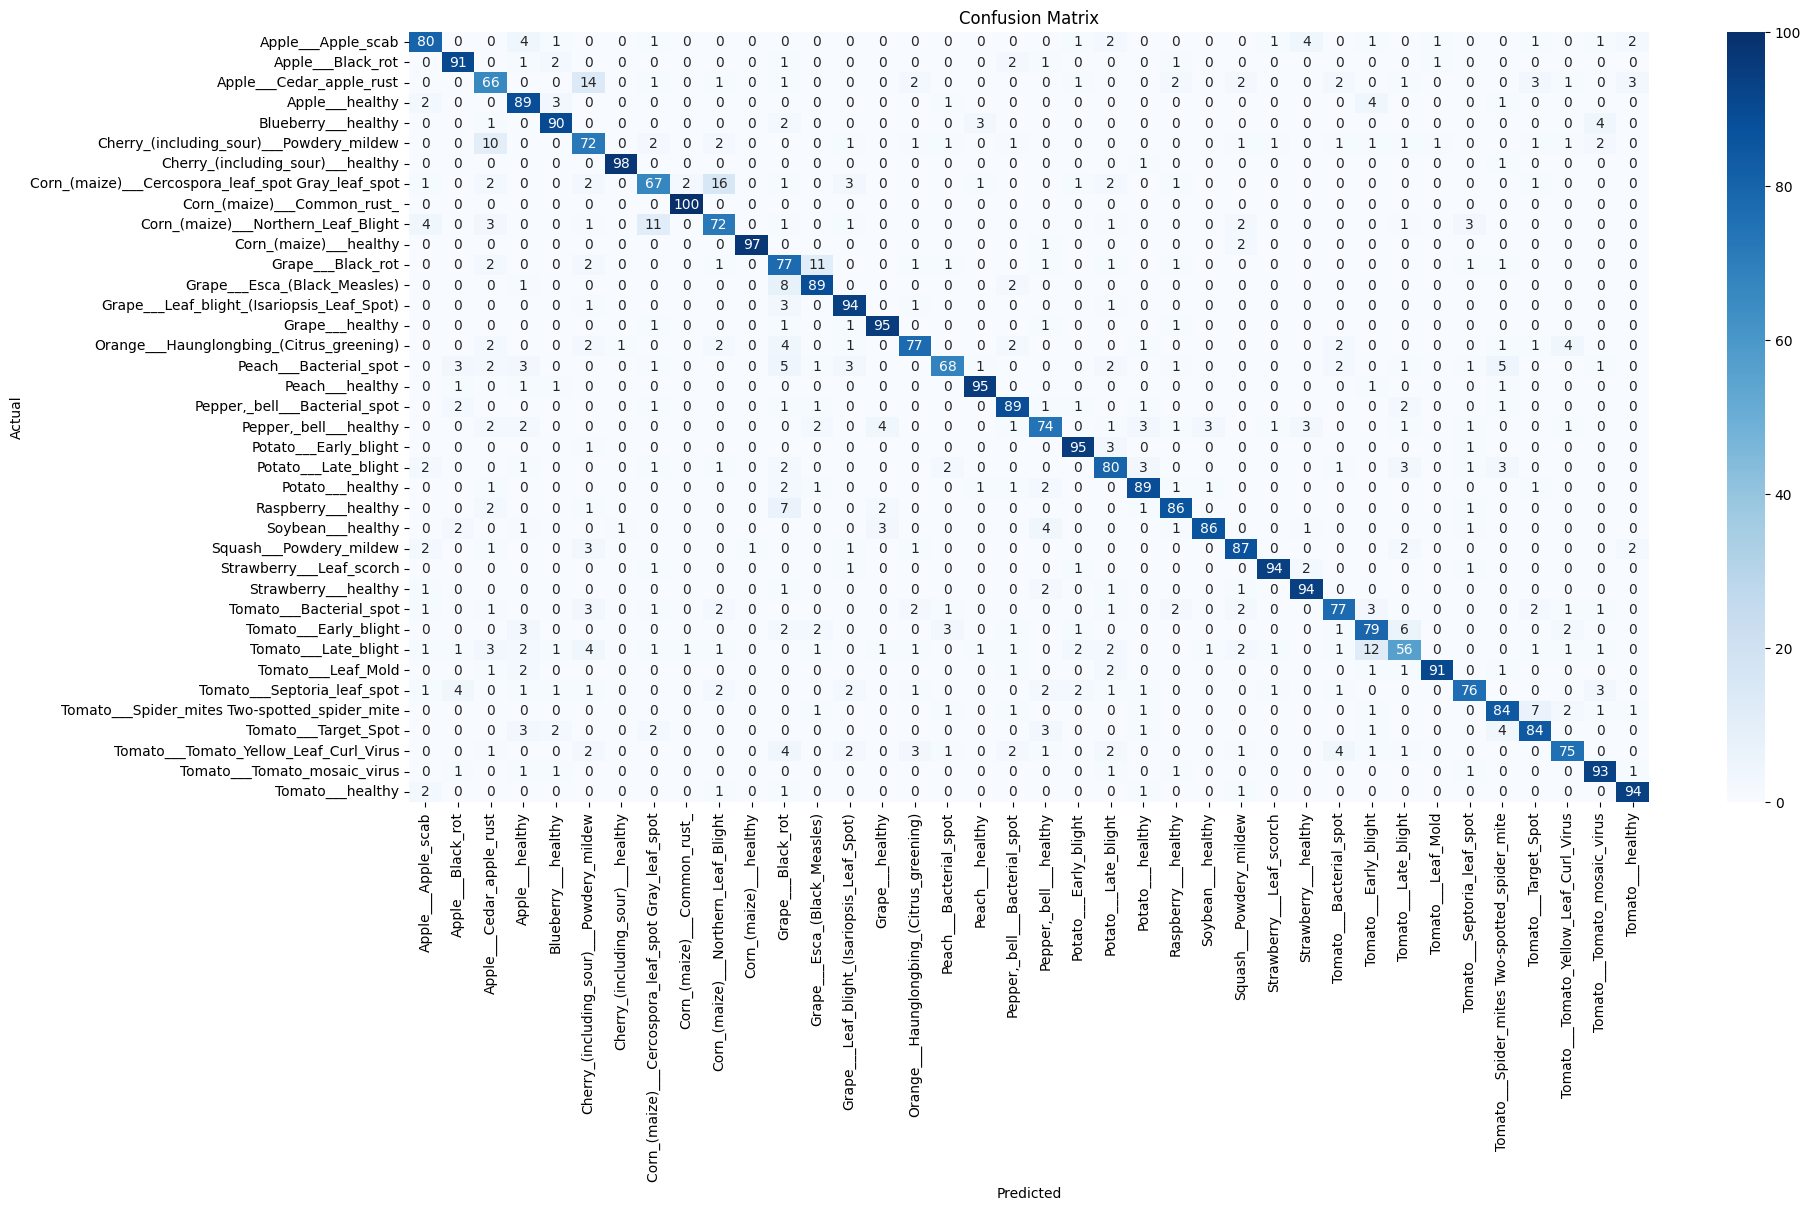

In [14]:

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(20, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [20]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


Validation Accuracy: 44.21%


In [21]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


Validation Accuracy: 23.32%


In [22]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [None, 10, 20],
              'min_samples_split': [2, 5, 10]}
grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters found:  {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Validation Accuracy: 82.76%
